# Notebook to compare modelled (MERRA-2, SNOWPACK, RACMO2, and MAR) vs observed SMB from IceBridge snow accumulation radar.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import xarray as xr
from osgeo import osr
from pyproj import Geod

## Load observed SMB from Dattler et. al., 2019

In [6]:
obs_lat, obs_lon, obs_accumulation, relative_accumulation, relative_accumulation_error = \
    np.loadtxt("/pl/active/nasa_smb/Data/Accumulation_Data_Product.csv", skiprows=1, delimiter=',', unpack=True)

# Transform obs lat/lon into epsg 3031

In [7]:
# Source and target EPSG
src = osr.SpatialReference()
tgt = osr.SpatialReference()
src.ImportFromEPSG(4326) # WGS-84
tgt.ImportFromEPSG(3031) # South Polar Stereo

# Define transformation
transform = osr.CoordinateTransformation(src, tgt)

# Initialize arrays
obs_X = np.zeros(len(obs_lon)); obs_X[:] = np.nan
obs_Y = np.zeros(len(obs_lon)); obs_Y[:] = np.nan

# Perform transformation
for j in range(0, len(obs_X)):
    coords = transform.TransformPoint(obs_lat[j], obs_lon[j]) # Lat, Lon
    obs_X[j], obs_Y[j] = coords[0:2]

## Load SNOWPACK SMB

In [8]:
# SNOWPACK SMB
nc_path = "../output/grids/a3d_grids.nc"
ds = xr.open_dataset(nc_path)

# SNOWPACK topography 
dem = np.loadtxt("../input/surface-grids/dem.asc", skiprows=6)
dem = xr.DataArray(dem, coords=[ds['northing'], ds['easting']], dims=['northing', 'easting'])

## Determine SNOWPACK domain corners

In [9]:
domain_left = ds['easting'].min()
domain_right = ds['easting'].max()
domain_bottom = ds['northing'].min()
domain_top = ds['northing'].max()

## Plot observed SMB (blue circles) and model domain (red rectangle)

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


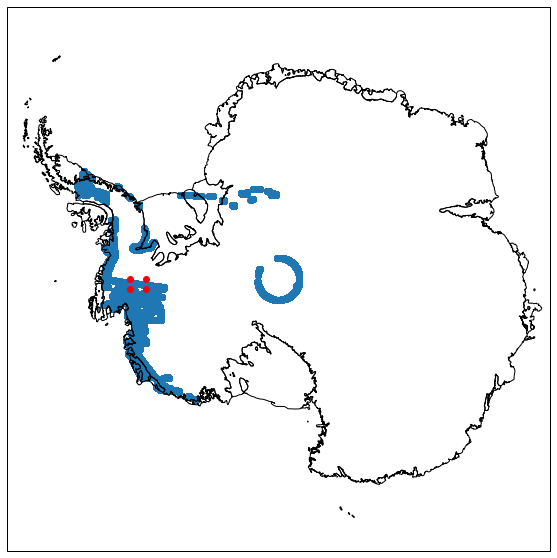

In [10]:
# Coastline Data
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

# Map
# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(10, 10))

# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# Plot obs locations
plt.scatter(obs_X, obs_Y)

# Plot model domain
plt.scatter(domain_left, domain_bottom, c='r')
plt.scatter(domain_left, domain_top, c='r')
plt.scatter(domain_right, domain_bottom, c='r')
plt.scatter(domain_right, domain_top, c='r')

## Determine indices of observations which are in SNOWPACK model domain

In [11]:
# Function to get indices of observations inside of the model domain
def get_domain_obs(obsX, obsY, obs_accum, domain_left, domain_right, domain_bottom, domain_top):
    '''
    Find obs whose X and Y are:
        X: greater than domain_left and less than domain_right
        Y: greater than domain_bottom and less than domain_top
    ''' 
    filter_func = np.vectorize(lambda obsX, obsY: obsX <= domain_right and obsX >= domain_left and obsY >= domain_bottom and obsY <= domain_top)
    obs_accum_filter = obs_accum[filter_func(obsX, obsY)]
    obsX_filter = obsX[filter_func(obsX, obsY)]
    obsY_filter = obsY[filter_func(obsX, obsY)]
    
    return obsX_filter, obsY_filter, obs_accum_filter

## Retrieve SNOWPACK and observed SMB 

In [12]:
# Retrieve observations
obs_X, obs_Y, obs_accumulation = get_domain_obs(obs_X, obs_Y, obs_accumulation, domain_left, domain_right, domain_bottom, domain_top)

In [13]:
# Retrieve SNOWPACK at observations
SNOWPACK_SMB = ds['swe'].isel(time=-1) - ds['swe'].isel(time=0)
SNOWPACK_SMB = SNOWPACK_SMB.sel(northing=obs_Y, easting=obs_X, method='nearest')
SNOWPACK_SMB = SNOWPACK_SMB.values.diagonal()
SNOWPACK_SMB = SNOWPACK_SMB / 1000

# Retrieve elevation at observations
dem = dem.sel(northing=obs_Y, easting=obs_X, method='nearest')
dem = dem.values.diagonal()

## Scatter plot of SNOWPACK and observed SMB

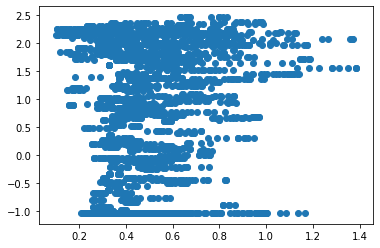

In [14]:
plt.scatter(obs_accumulation, SNOWPACK_SMB)

## Horizontal ransect of SNOWPACK vs obserced SMB

Text(0, 0.5, 'Elevation [m]')

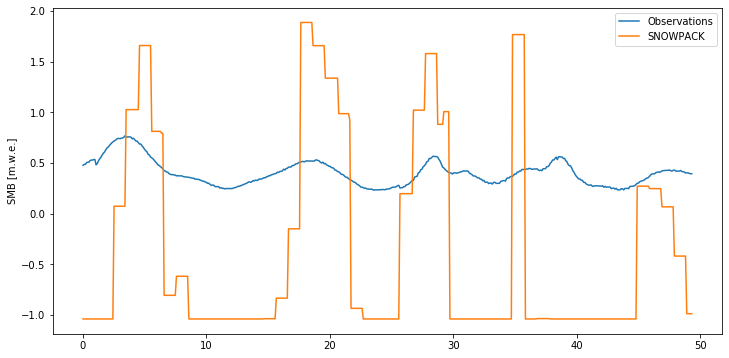

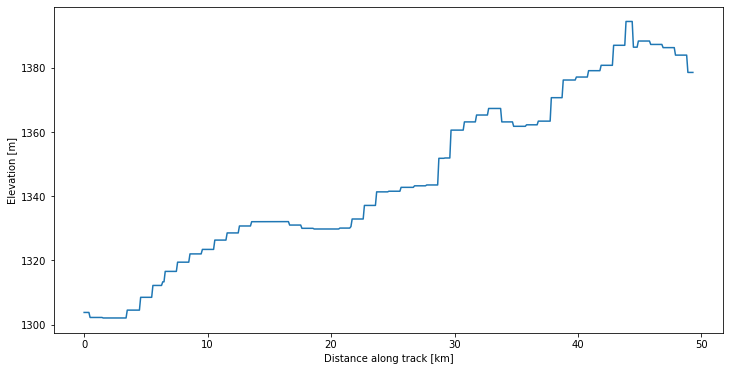

In [15]:
# Indices to plot
ind0 = 1500
indf = 2000
indices = np.arange(ind0, indf)

# Calculate distance along track (dat)
dat = np.zeros(len(indices)); dat[:] = np.nan
x0 = obs_X[ind0]; y0 = obs_Y[ind0]
count = -1 # Add hock index counter 

for j in range(ind0, indf):
    count = count + 1
    dat[count] = np.sqrt(np.square(obs_X[j] - x0) + np.square(obs_Y[j] - y0)) / 1000

# Plot 
plt.figure(figsize=(12,6))
plt.plot(dat, obs_accumulation[indices], label='Observations')
plt.plot(dat, SNOWPACK_SMB[indices], label="SNOWPACK")
plt.legend()
plt.ylabel("SMB [m.w.e.]")

plt.figure(figsize=(12,6))
plt.plot(dat, dem[indices], label="Elevation")
plt.xlabel("Distance along track [km]")
plt.ylabel("Elevation [m]")


In [17]:
ds['easting']

<xarray.DataArray 'easting' (easting: 168)>
array([-1542000., -1541000., -1540000., -1539000., -1538000., -1537000.,
       -1536000., -1535000., -1534000., -1533000., -1532000., -1531000.,
       -1530000., -1529000., -1528000., -1527000., -1526000., -1525000.,
       -1524000., -1523000., -1522000., -1521000., -1520000., -1519000.,
       -1518000., -1517000., -1516000., -1515000., -1514000., -1513000.,
       -1512000., -1511000., -1510000., -1509000., -1508000., -1507000.,
       -1506000., -1505000., -1504000., -1503000., -1502000., -1501000.,
       -1500000., -1499000., -1498000., -1497000., -1496000., -1495000.,
       -1494000., -1493000., -1492000., -1491000., -1490000., -1489000.,
       -1488000., -1487000., -1486000., -1485000., -1484000., -1483000.,
       -1482000., -1481000., -1480000., -1479000., -1478000., -1477000.,
       -1476000., -1475000., -1474000., -1473000., -1472000., -1471000.,
       -1470000., -1469000., -1468000., -1467000., -1466000., -1465000.,
       -1464000., -1463000., -1462000., -1461000., -1460000., -1459000.,
       -1458000., -1457000., -1456000., -1455000., -1454000., -1453000.,
       -1452000., -1451000., -1450000., -1449000., -1448000., -1447000.,
       -1446000., -1445000., -1444000., -1443000., -1442000., -1441000.,
       -1440000., -1439000., -1438000., -1437000., -1436000., -1435000.,
       -1434000., -1433000., -1432000., -1431000., -1430000., -1429000.,
       -1428000., -1427000., -1426000., -1425000., -1424000., -1423000.,
       -1422000., -1421000., -1420000., -1419000., -1418000., -1417000.,
       -1416000., -1415000., -1414000., -1413000., -1412000., -1411000.,
       -1410000., -1409000., -1408000., -1407000., -1406000., -1405000.,
       -1404000., -1403000., -1402000., -1401000., -1400000., -1399000.,
       -1398000., -1397000., -1396000., -1395000., -1394000., -1393000.,
       -1392000., -1391000., -1390000., -1389000., -1388000., -1387000.,
       -1386000., -1385000., -1384000., -1383000., -1382000., -1381000.,
       -1380000., -1379000., -1378000., -1377000., -1376000., -1375000.],
      dtype=float32)
Coordinates:
  * easting  (easting) float32 -1542000.0 -1541000.0 ... -1376000.0 -1375000.0
Attributes:
    standard_name:  projection_x_coordinate
    units:          m
    axis:           X

## Normalized observations and models

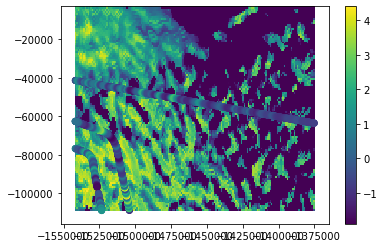

In [30]:
# Load in 1980 SNOWPACK SWE
x_snowpack = ds['easting']
y_snowpack = ds['northing']
swe = ds['swe'].isel(time=-1) - ds['swe'].isel(time=0)

# Normalize data
swe_norm = (swe - np.mean(swe)) / np.std(swe)
obs_swe_norm = (obs_accumulation - np.nanmean(obs_accumulation)) / np.nanstd(obs_accumulation)

plt.pcolormesh(x_snowpack, y_snowpack, swe_norm)
plt.scatter(obs_X, obs_Y, c=obs_swe_norm)
plt.colorbar()
